# Notebook to create JOSS article figures

*Martin Vonk (2025)*

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from cycler import cycler
from matplotlib import patheffects

import spei as si

# matplotlib settings
plt.rcParams.update(
    {
        "axes.prop_cycle": cycler(
            color=[
                "#3f90da",
                "#ffa90e",
                "#bd1f01",
                "#94a4a2",
                "#832db6",
                "#a96b59",
                "#e76300",
                "#b9ac70",
                "#717581",
                "#92dadd",
            ]
        ),
        "axes.titlesize": 7.0,
        "axes.labelsize": 7.0,
        "xtick.labelsize": 6.0,
        "ytick.labelsize": 6.0,
        "legend.fontsize": 7.0,
        "legend.framealpha": 1.0,
    }
)

In [2]:
df = pd.read_csv("data/series.csv", index_col=0, parse_dates=True)
prec = df["prec"]
evap = df["evap"]
surplus = prec - evap
surplusm = surplus.resample("MS").sum()
head = df["head"]

In [3]:
dist = sps.fisk
sispei = si.SI(
    series=surplusm,
    dist=dist,
    timescale=1,
)
sispei.fit_distribution()

month = list(sispei._dist_dict.keys())[2]

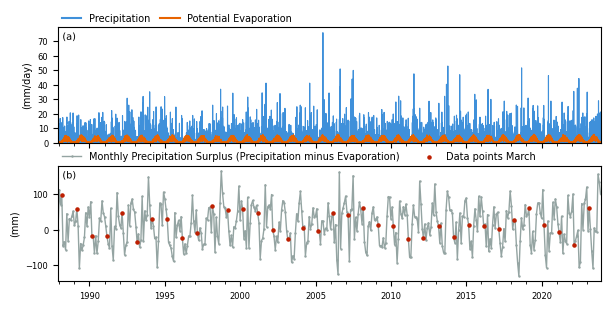

In [4]:
fig, axd = plt.subplot_mosaic([["meteo"], ["sp"]], figsize=(7.0, 3.3), sharex=True)

axd["meteo"].plot(prec.index, prec, linewidth=0.8, color="C0")  # "#4477AA"
axd["meteo"].plot(evap.index, evap, linewidth=0.8, color="C6")
axd["meteo"].plot([], [], color="C0", label="Precipitation")
axd["meteo"].plot([], [], color="C6", label="Potential Evaporation")

axd["meteo"].legend(loc=(0, 1), ncol=2, frameon=False, columnspacing=1.0)
axd["meteo"].set_ylabel("(mm/day)")

axd["meteo"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
axd["meteo"].set_ylim(bottom=0.0)

axd["meteo"].annotate(
    "(a)",
    xy=(0.008, 0.96),
    xycoords="axes fraction",
    fontsize=plt.rcParams["axes.titlesize"],
    horizontalalignment="left",
    verticalalignment="top",
    path_effects=[
        patheffects.Stroke(linewidth=1, foreground="white"),
        patheffects.Normal(),
    ],
)

axd["sp"].plot(
    sispei.series.index,
    sispei.series.values,
    color="C3",
    linewidth=1.0,
    marker=".",
    markersize=1.5,
    label="Monthly Precipitation Surplus (Precipitation minus Evaporation)",
)
mid = sispei.series.index.month == month.month
axd["sp"].scatter(
    sispei.series.index[mid],  # + pd.Timedelta(days=15),
    sispei.series.values[mid],
    color="C2",
    s=5.0,
    zorder=2,
    label=f"Data points {month.strftime('%B')}",
)
axd["sp"].xaxis.set_minor_locator(mpl.dates.YearLocator(1))
axd["sp"].xaxis.set_major_locator(mpl.dates.YearLocator(5))
axd["sp"].set_xlim(sispei.series.index[0], sispei.series.index[-1])
axd["sp"].set_ylabel("(mm)")
axd["sp"].legend(loc=(0, 1), frameon=False, ncol=2)
axd["sp"].annotate(
    "(b)",
    xy=(0.008, 0.96),
    xycoords="axes fraction",
    fontsize=plt.rcParams["axes.titlesize"],
    horizontalalignment="left",
    verticalalignment="top",
    path_effects=[
        patheffects.Stroke(linewidth=1, foreground="white"),
        patheffects.Normal(),
    ],
)

fig.savefig("figures/monthly_precipitation_surplus.png", dpi=300, bbox_inches="tight")

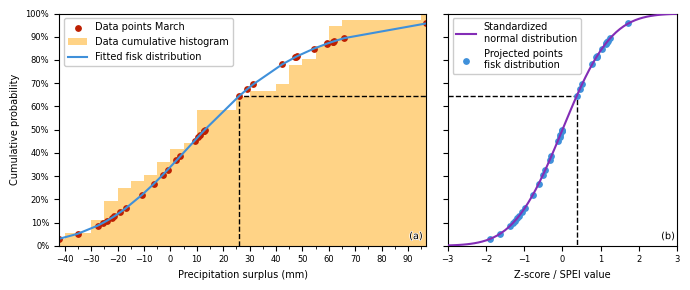

In [5]:
fit_dist = sispei._dist_dict[month]
data = fit_dist.data.sort_values()
cdf = fit_dist.cdf().loc[data.index]

zscores = np.arange(-3.0, 3.1, 0.1)
norm_cdf = sps.norm.cdf(zscores, loc=0.0, scale=1.0)
norm_cdf_transformed = sps.norm.ppf(cdf.values, loc=0.0, scale=1.0)

bin = 5.0
bins = np.arange(data.min() // bin * bin, data.max() + bin, bin)

fig, axd = plt.subplot_mosaic(
    [["cdf", "norm"]],
    figsize=(7.0, 3),
    width_ratios=[1.6, 1.0],
    sharey=True,
    layout="tight",
)
axd["cdf"].scatter(
    data, cdf, s=15.0, label=f"Data points {month.strftime('%B')}", color="C2", zorder=2
)
axd["cdf"].hist(
    data,
    bins=bins,
    density=True,
    cumulative=True,
    alpha=0.5,
    label="Data cumulative histogram",
    color="C1",
    zorder=0,
)
axd["cdf"].plot(data, cdf, label=f"Fitted {dist.name} distribution", color="C0")
axd["cdf"].legend(loc="upper left")
axd["cdf"].set_xlim(np.min(data), np.max(data))
axd["cdf"].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(bin))
axd["cdf"].xaxis.set_major_locator(mpl.ticker.MultipleLocator(bin * 2))
axd["cdf"].set_ylim(0.0, 1.0)
axd["cdf"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
axd["cdf"].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
axd["cdf"].set_xlabel("Precipitation surplus (mm)")
axd["cdf"].set_ylabel("Cumulative probability")
axd["cdf"].annotate(
    "(a)",
    xy=(0.99, 0.02),
    xycoords="axes fraction",
    fontsize=mpl.rcParams["axes.titlesize"],
    horizontalalignment="right",
    verticalalignment="bottom",
    path_effects=[
        patheffects.Stroke(linewidth=1, foreground="white"),
        patheffects.Normal(),
    ],
)

axd["norm"].plot(
    zscores, norm_cdf, label="Standardized\nnormal distribution", color="C4", zorder=3
)
axd["norm"].scatter(
    norm_cdf_transformed,
    cdf.values,
    s=15.0,
    label=f"Projected points\n{dist.name} distribution",
    color="C0",
    zorder=2,
)
axd["norm"].legend(loc="upper left")
axd["norm"].set_xlim(np.min(zscores), np.max(zscores))
axd["norm"].set_xlabel("Z-score / SPEI value")

# visualize specific data point
idx = data.index[21]
axd["cdf"].plot(
    [data.loc[idx], data.loc[idx], np.max(data)],
    [0.0, cdf.loc[idx], cdf.loc[idx]],
    color="k",
    linestyle="--",
    linewidth=1.0,
    zorder=1,
)
axd["norm"].plot(
    [np.min(zscores), sps.norm.ppf(cdf.loc[idx]), sps.norm.ppf(cdf.loc[idx])],
    [
        cdf.loc[idx],
        cdf.loc[idx],
        0.0,
    ],
    color="k",
    linestyle="--",
    linewidth=1.0,
    zorder=1,
)
axd["norm"].annotate(
    "(b)",
    xy=(0.99, 0.02),
    xycoords="axes fraction",
    fontsize=mpl.rcParams["axes.titlesize"],
    horizontalalignment="right",
    verticalalignment="bottom",
    path_effects=[
        patheffects.Stroke(linewidth=1, foreground="white"),
        patheffects.Normal(),
    ],
)

fig.savefig("figures/surplus_fit_cdf.png", dpi=300, bbox_inches="tight")

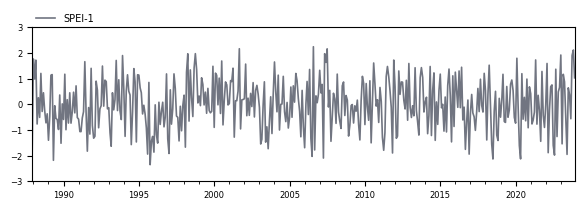

In [6]:
spei1 = sispei.norm_ppf()

fig, ax = plt.subplots(figsize=(7.0, 2.0))
ax.plot(spei1.index, spei1.values, linewidth=1.2, label="SPEI-1", color="C8")
ax.set_yticks(
    np.arange(-3.0, 4.0, 1.0),
)
ax.set_xlim(spei1.index[0], spei1.index[-1])
ax.set_ylim(-3.0, 3.0)
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(1))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(5))
ax.legend(loc=(0, 1), frameon=False, ncol=2)

fig.savefig("figures/spei1.png", dpi=300, bbox_inches="tight")

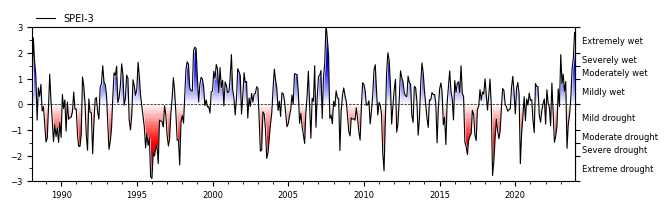

In [7]:
spei3 = si.spei(series=surplusm, dist=sps.gamma, timescale=3)

ax = si.plot.si(spei3, figsize=(7.0, 2.0))
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(1))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(5))
ax.legend(labels=["SPEI-3"], loc=(0, 1), frameon=False)

ax.get_figure().savefig("figures/spei3.png", dpi=300, bbox_inches="tight")

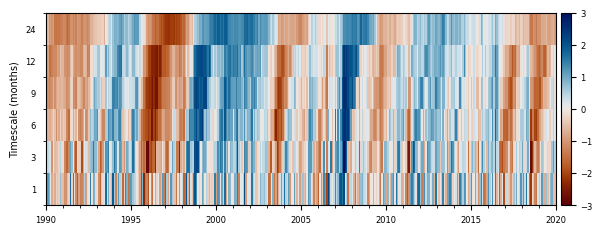

In [8]:
speis = [
    spei1.rename("1"),
    spei3.rename("3"),
    si.spei(surplusm, timescale=6).rename("6"),
    si.spei(surplusm, timescale=9).rename("9"),
    si.spei(surplusm, timescale=12).rename("12"),
    si.spei(surplusm, timescale=24).rename("24"),
]
f, ax = plt.subplots(figsize=(7.0, 2.5))
si.plot.heatmap(speis, cmap="vik_r", vmax=3, add_category=False, ax=ax)
ax.set_ylabel("Timescale (months)")
ax.xaxis.set_major_locator(mpl.dates.YearLocator(5))
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(1))
ax.set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))
ax.get_figure().savefig("figures/spei_heatmap.png", dpi=300, bbox_inches="tight")

In [9]:
spi3 = si.SI(series=prec, dist=sps.gamma, timescale=30, prob_zero=True)
spi3.fit_distribution()

spi3._dist_dict[pd.Timestamp("2000-02-29")]

Dist(dist=<scipy.stats._continuous_distns.gamma_gen object at 0x7f0446ab8860>, loc=np.float64(-660.3690993133646), scale=np.float64(1.634966427261619))